In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import sparse
import json
from datetime import datetime
import warnings

import pcg_skel
from cloudvolume import CloudVolume
from caveclient import CAVEclient

In [111]:
euc_dist_step = 100 * 1000
path_dist_step = 100 * 1000
rad_dist_step = 25 * 1000
nsteps = 1000
cache_dir = "..\\data\\"
pre_type = "BPC"
trash = False
max_hist_dist = 2_000_000
num_syns_cutoff = 100
split_quality_cutoff = 0.5
require_in_col = False  # this requires the pre- and post-synaptic cells to be in the proofread column, in which all cells were manually cell-typed
allow_clean = True
inh_cell_types = ["BPC", "BC", "MC", "NGC"]

datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [112]:
# client.auth.get_new_token()  # <-- use this the first time to get a token
# client.auth.save_token( )

## Find a presynaptic cell of type `pre_type` that's been proofread to investigate

In [113]:
all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
cells_by_nuc = all_cells.copy()
cells_by_nuc.index = cells_by_nuc.id

In [114]:
# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

col_cells = all_cells[all_cells.pt_position.apply(in_bbox)]

In [115]:
# use this cell if you want to go through the cells one at a time
# gather a list of thoroughly proofread layer 2/3 pyramidal cells
proofreading_status = client.materialize.query_table('proofreading_status_public_release')
proofread_cells = proofreading_status.query(f"(status_axon == 'extended' or (status_axon == 'clean' and {allow_clean})) and valid_id == pt_root_id")
pre_type_cells = all_cells.query(f"cell_type == '{pre_type}'")
root_ids_to_study = list(set.intersection(set(pre_type_cells.pt_root_id.unique()), set(proofread_cells.valid_id.unique())))
if require_in_col:
    root_ids_to_study = list(set.intersection(set(root_ids_to_study), col_cells.pt_root_id.unique()))
nucs_to_study = list(cells_by_root.id.loc[root_ids_to_study].values)  # permanent nucleus id of cell
print(len(root_ids_to_study), len(nucs_to_study))
if len(root_ids_to_study) != len(nucs_to_study):
    raise ValueError("Some cells were not proofread properly")

28 28


In [116]:
nuc_id = nucs_to_study.pop()  # look at the next thoroughly proofread pre-synaptic cell
cell_root_id = cells_by_nuc.pt_root_id.loc[nuc_id]
cell_root_id, nuc_id, nucs_to_study

(864691135367077881,
 292721,
 [258293,
  260718,
  304980,
  258379,
  298802,
  294704,
  262642,
  258365,
  260724,
  296527,
  298894,
  256543,
  262909,
  301200,
  260468,
  262957,
  301030,
  262692,
  256426,
  292675,
  292831,
  298829,
  258362,
  298961,
  262898,
  258281,
  292867])

In [117]:
# cells_str = ",\n".join(map(str, nucs_to_study))
# with open(os.path.join(cache_dir, "cells.txt"), "w") as f:
#     f.write(cells_str)

In [118]:
# # run this command to run this notebook for all 20 cells
# # for /l %x in (1, 1, 41) do jupyter nbconvert --to notebook --execute --inplace synapse_analysis.ipynb
# with open(os.path.join(cache_dir, "cells.txt"), "r") as f:  # cells.txt is just a list of the 20 proofread cells above
#     nucs_to_study = list(map(int, f.read().split(",\n")))

# nuc_id = nucs_to_study.pop()  # look at the next thoroughly proofread layer 2/3 pyramidal cell
# cell_root_id = cells_by_nuc.pt_root_id.loc[nuc_id]
# cells_str = ",\n".join(map(str, nucs_to_study))
# print(cell_root_id, nuc_id)
# with open(os.path.join(cache_dir, "cells.txt"), "w") as f:  
#     f.write(cells_str)

In [119]:
cell_data = all_cells.query(f"pt_root_id == {cell_root_id}")
root_point = cell_data['pt_position'].iloc[0]
cell_data

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,num_soma
19794,292721,t,aibs_coarse_inhibitory,BPC,90149783800585863,864691135367077881,"[184432, 116416, 21136]",1


### Set up storage of results

In [120]:
results_dict = {"parameters": {"pre_type": pre_type, "split_quality_cutoff": split_quality_cutoff, "num_syns_cutoff": num_syns_cutoff, "nsteps": nsteps, "max_hist_dist": max_hist_dist, "euc_dist_step": euc_dist_step, "path_dist_step": path_dist_step, "rad_dist_step": rad_dist_step, "require_in_col": require_in_col}}
results_fname = str(nuc_id) + "_" + str(datetime.now()).replace(" ", "_").replace(":", ".")
clean_status = "clean" if allow_clean else "extended"
col_status = "-col" if require_in_col else ""
trash_status = "-trash" if trash else ""
results_dir = os.path.join(cache_dir, "results", f"{pre_type}-{clean_status}-subclass{col_status}")
results_path = os.path.join(results_dir, results_fname + ".json")

In [121]:
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    os.mkdir(os.path.join(results_dir, "cumulative"))

## Get the neuron

In [122]:
nrn_cache_dir = os.path.join(cache_dir, "nrns")
try:
    print("Loading neuron from cache...", end="")
    nrn = pcg_skel.meshwork.load_meshwork(os.path.join(nrn_cache_dir, str(nuc_id) + '.h5'))
    print(" successful.")
except FileNotFoundError as e:
    print(" cached skeleton not found. Generating skeleton.")
    print("\t", e)
    nrn = pcg_skel.pcg_meshwork(
                    cell_root_id,
                    client=client,
                    root_point=root_point,
                    root_point_resolution=[4, 4, 40],
                    collapse_soma=True,
                    invalidation_d=3,
                    synapse_table='synapses_pni_2',
                    synapses="all",
                    refine='all',
                    cache=os.path.join(cache_dir, "l2lookup.sqlite"),
                    save_to_cache=True
                )
    nrn.save_meshwork(os.path.join(nrn_cache_dir, str(nuc_id) + '.h5'))

# find the synapses on the axon
is_axon, split_quality = pcg_skel.meshwork.algorithms.split_axon_by_synapses(
    nrn, nrn.anno.pre_syn.skel_index, nrn.anno.post_syn.skel_index
)
nrn.anno.add_annotations("is_axon", is_axon, mask=True)
if split_quality < split_quality_cutoff:
    raise ValueError(f"Axon may not have been found with split quality {split_quality}")
split_quality

Loading neuron from cache... successful.


0.8991191141439971

In [123]:
output_df = nrn.anno.pre_syn.df
output_df["skel_idx"] = nrn.anno.pre_syn.mesh_index.to_skel_index_padded  # maps to the index of the nearest skeleton vertex
output_df = output_df[nrn.anno.is_axon.mesh_mask[output_df.pre_pt_mesh_ind]] # only look at synapses on the axon, because those on the dendrites are mislabelled

## Clean the data further

In [124]:
roots_with_soma = set(cells_by_root.index)

In [125]:
# not falsely merged
#                   root_id is of a cell       and there is only 1 soma associated with it
include = np.array([root_id in roots_with_soma and type(cells_by_root.id.loc[root_id]) == np.int64 for root_id in output_df.post_pt_root_id])
if require_in_col:
    # in column
    col_root_ids = set(col_cells.pt_root_id.values)
    include &= np.array([c in col_root_ids for c in output_df.post_pt_root_id])
# other possible criteria: proofread, in one of the other tables

# finally filter by the above criteria
clean_output_df = output_df[include].copy()

if len(clean_output_df.post_pt_root_id) < num_syns_cutoff and not require_in_col:  # skip if there are unreasonably few clean connections
    raise ValueError("Not enough clean synapses")

In [126]:
# convert to json serializable format
clean_output_df = pd.read_json(clean_output_df.to_json())

# Count its synapse types

In [127]:
# # Look at a pyramidal neuron, count its synapse types
def get_prop_type(target_cells, cell_type):
    # target cells are intentionally not necessarily unique
    cell_types = cells_by_root.cell_type.loc[target_cells]
    print("n =", len(cell_types))
    return sum(cell_types.values == cell_type) / len(cell_types) if len(cell_types) > 0 else np.nan

for cell_type in inh_cell_types:
    p = get_prop_type(target_cells=clean_output_df.post_pt_root_id, cell_type=cell_type)
    print(f"post syn {cell_type} proportion given pre is {pre_type}:", p)
    results_dict[f"post_syn_{cell_type}_given_pre_{pre_type}"] = {"p": p, "n": len(clean_output_df.post_pt_root_id)}

n = 737
post syn BPC proportion given pre is BPC: 0.018995929443690638
n = 737
post syn BC proportion given pre is BPC: 0.08276797829036635
n = 737
post syn MC proportion given pre is BPC: 0.08548168249660787
n = 737
post syn NGC proportion given pre is BPC: 0.0013568521031207597


## Soma-to-soma distance

In [128]:
def vx_to_nm(p):
    return p * resolution

def soma_to_soma_dist(post_id):
    possible = cells_by_root.loc[post_id]
    if possible.num_soma > 1: # falsely merged cell (shouldn't happen if data is clean)
        print("false merge")
        return np.nan
    if possible.num_soma == 0: 
        print("no nucleus associated with post-synapse")
        return np.nan
    post_loc = vx_to_nm(possible.pt_position)
    return np.sqrt(np.sum((post_loc - soma_loc) ** 2))

soma_loc = vx_to_nm(cell_data.pt_position.iloc[0])
clean_output_df["soma_to_soma_dist"] = clean_output_df.post_pt_root_id.apply(soma_to_soma_dist)
clean_output_df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,soma_to_soma_dist
0,"[189398, 186518, 21803]",179365341,"[189414, 186526, 21811]",864691135104181325,90792517133805779,162850111171330469,3997,"[189338, 186538, 21802]",864691135367077881,90792517133805930,1140,t,2357,293740.489548
1,"[189460, 136370, 20265]",180660441,"[189386, 136340, 20262]",864691135407382985,90785782423740805,162843445180760690,3943,"[189468, 136412, 20268]",864691135367077881,90785851143238674,2712,t,2331,154666.643126
2,"[182032, 146775, 21623]",167530032,"[182126, 146738, 21631]",864691136109120184,89802063315379270,161859657353134131,2006,"[182062, 146794, 21633]",864691135367077881,89802063315378595,17732,t,1165,152874.635803
4,"[187990, 144632, 21333]",177781158,"[188054, 144690, 21330]",864691136031639739,90646213300740230,162703738618773962,3653,"[188022, 144558, 21325]",864691135367077881,90646144581270380,4724,t,2149,145427.429160
5,"[169480, 113236, 22351]",142677278,"[169446, 113234, 22353]",864691136088942135,88038309292838742,160166272074514831,202,"[169528, 113198, 22349]",864691135367077881,88108678036994879,1176,t,98,220667.281272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,"[193090, 181978, 21887]",185605695,"[193116, 181920, 21886]",864691135799903330,91354848611989959,163342142624760503,4685,"[193052, 182002, 21883]",864691135367077881,91284548587296640,1152,t,2794,277912.490975
952,"[184316, 124444, 20691]",170798824,"[184236, 124470, 20688]",864691136227075409,90080514500984458,162138108538650861,2341,"[184268, 124448, 20687]",864691135367077881,90080514500982439,2188,t,1353,169451.660411
954,"[179641, 94105, 20297]",165579277,"[179672, 94182, 20291]",864691136311738173,89443141287269001,161500735324816450,1443,"[179670, 94204, 20293]",864691135367077881,89443141287273318,8424,t,857,316035.207760
955,"[183555, 157690, 21476]",163988648,"[183544, 157638, 21484]",864691135501817437,90014612590192202,162072206627570742,2266,"[183616, 157766, 21490]",864691135367077881,90014612590205307,1148,t,1305,492509.424982


# Find the distance from the soma to each synapse (euclidean, then dijkstra)
## Euclidean

In [129]:
ctr_locs = np.stack(clean_output_df.ctr_pt_position.apply(vx_to_nm).values)  # of synapses
clean_output_df["euc_dist"] = np.sqrt(np.sum((ctr_locs - soma_loc.reshape(1, 3))**2, axis=1))

## Radial (ignoring depth)

In [130]:
clean_output_df["rad_dist"] = np.sqrt(np.sum((ctr_locs[:, [0, 2]] - soma_loc.reshape(1, 3)[:, [0, 2]])**2, axis=1))

## Path-length

In [131]:
skel_vertices = nrn.skeleton.vertices
skel_csgraph = nrn.skeleton.csgraph
idx_of_soma = int(nrn.skeleton.root)

# csgraph stands for compressed sparse graph
ds = sparse.csgraph.dijkstra(skel_csgraph,
                             directed=False,
                             indices=idx_of_soma)
if not all(np.isfinite(ds)):
    raise RuntimeError("Dijkstra's algorithm on the skeleton did not find a solution")

In [132]:
clean_output_df["path_dist"] = ds[clean_output_df.skel_idx]
# clean_output_df but split into the various cell types
syn_dfs = {"exc": clean_output_df[cells_by_root.classification_system.loc[clean_output_df.post_pt_root_id].values == "aibs_coarse_excitatory"]}
for cell_type in inh_cell_types:
    is_type = cells_by_root.cell_type.loc[clean_output_df.post_pt_root_id].values == cell_type
    syn_dfs[cell_type] = clean_output_df[is_type]

unplotted = clean_output_df[clean_output_df["path_dist"] > max_hist_dist]
if len(unplotted) > 0:
    warnings.warn("Some data is not captured by the histogram")
    print(unplotted)

## Results and Figures!

In [133]:
density = False  # whether to use the counts or density for the histogram
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
path_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    path_hists[cell_type] = np.histogram(syn_dfs[cell_type].path_dist, bins=path_bin_edges, density=density)[0]

euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
euc_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    euc_hists[cell_type] = np.histogram(syn_dfs[cell_type].euc_dist, bins=euc_bin_edges, density=density)[0]
    
rad_bin_edges = np.arange(0, max_hist_dist, rad_dist_step)
rad_bin_centers = (rad_bin_edges[1:] + rad_bin_edges[:-1]) / 2
rad_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    rad_hists[cell_type] = np.histogram(syn_dfs[cell_type].rad_dist, bins=rad_bin_edges, density=density)[0]

In [134]:
# contniuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
step_size = max_hist_dist / nsteps
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)
rad_bin_locs = np.linspace(rad_dist_step / 2, max_hist_dist - rad_dist_step / 2, nsteps)
euc_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
path_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
rad_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])

for i in range(nsteps):
    euc_c = euc_bin_locs[i]
    euc_l = euc_c - euc_dist_step / 2
    euc_r = euc_c + euc_dist_step / 2
    for cell_type in syn_dfs:
        euc_densities[cell_type][i] = sum((euc_l < syn_dfs[cell_type].euc_dist).values & (syn_dfs[cell_type].euc_dist < euc_r).values) / euc_dist_step
    path_c = path_bin_locs[i]
    path_l = path_c - path_dist_step / 2
    path_r = path_c + path_dist_step / 2
    for cell_type in syn_dfs:
        path_densities[cell_type][i] = sum((path_l < syn_dfs[cell_type].path_dist).values & (syn_dfs[cell_type].path_dist < path_r).values) / path_dist_step
    rad_c = rad_bin_locs[i]
    rad_l = rad_c - rad_dist_step / 2
    rad_r = rad_c + rad_dist_step / 2
    for cell_type in syn_dfs:
        rad_densities[cell_type][i] = sum((rad_l < syn_dfs[cell_type].rad_dist).values & (syn_dfs[cell_type].rad_dist < rad_r).values) / rad_dist_step

In [135]:
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density
p_type_by_rad_dists = dict()
rad_total_density = sum(rad_densities[t] for t in rad_densities)
for cell_type in rad_densities:
    p_type_by_rad_dists[cell_type] = rad_densities[cell_type] / rad_total_density


C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [136]:
def to_dict_list(d):
    """converts a dictionary of np arrays to a dictionary of lists"""
    return dict([(k, d[k].tolist()) for k in d])
results_dict["euc_hists"] = to_dict_list(euc_hists)
results_dict["path_hists"] = to_dict_list(path_hists)
results_dict["rad_hists"] = to_dict_list(rad_hists)
results_dict["euc_densities"] = to_dict_list(euc_densities)
results_dict["path_densities"] = to_dict_list(path_densities)
results_dict["rad_densities"] = to_dict_list(rad_densities)
results_dict["p_type_by_path_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["p_type_by_euc_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["p_type_by_rad_dists"] = to_dict_list(p_type_by_rad_dists)
results_dict["clean_output_dict"] = clean_output_df.to_dict()
results_dict["syn_dicts"] = dict((key, syn_dfs[key].to_dict()) for key in syn_dfs)

with open(results_path, "w") as f:
    f.write(json.dumps(results_dict))

In [137]:
plot_colors = ["lime", "darkorchid", "gold", "orangered", "dodgerblue"]
type_colors = dict(zip(syn_dfs.keys(), plot_colors))

C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ATMal\miniconda3\envs\

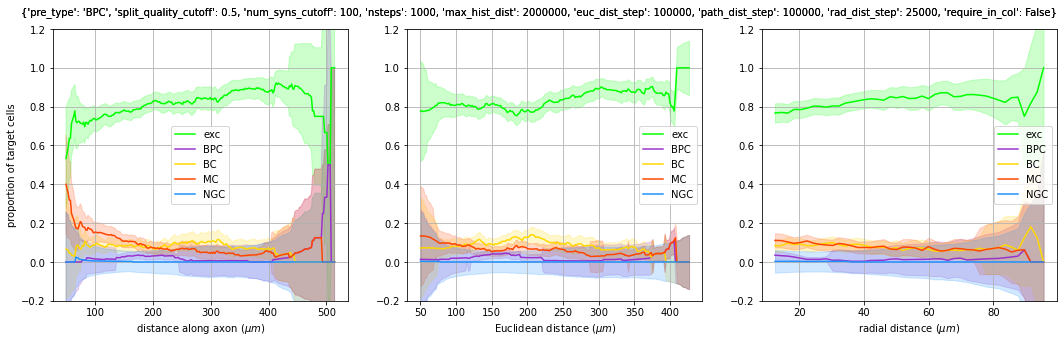

In [138]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for cell_type in syn_dfs:
    p = p_type_by_path_dists[cell_type]
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    curr_n = (path_dist_step * path_total_density)
    se = np.where((curr_n * p >= 5) & (curr_n * (1 - p) >= 5), np.sqrt(p * (1 - p) / curr_n), np.sqrt(0.25 / curr_n))
    axes[0].fill_between(path_bin_locs/1000, p - 2 * se, p + 2 * se, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
axes[0].set_ylim((-0.2, 1.2))
for cell_type in syn_dfs:
    p = p_type_by_euc_dists[cell_type]
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    curr_n = (path_dist_step * path_total_density)
    se = np.where((curr_n * p >= 5) & (curr_n * (1 - p) >= 5), np.sqrt(p * (1 - p) / curr_n), np.sqrt(0.25 / curr_n))
    axes[1].fill_between(euc_bin_locs/1000, p - 2 * se, p + 2 * se, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
axes[1].set_ylim((-0.2, 1.2))
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
for cell_type in syn_dfs:
    p = p_type_by_rad_dists[cell_type]
    axes[2].plot(rad_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    curr_n = (rad_dist_step * rad_total_density)
    se = np.where((curr_n * p >= 5) & (curr_n * (1 - p) >= 5), np.sqrt(p * (1 - p) / curr_n), np.sqrt(0.25 / curr_n))
    axes[2].fill_between(rad_bin_locs/1000, p - 2 * se, p + 2 * se, color=type_colors[cell_type], alpha=0.2)
axes[2].set_xlabel("radial distance ($\mu m$)")
axes[2].legend()
axes[2].grid()
axes[2].set_ylim((-0.2, 1.2))
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [139]:
fig.savefig(os.path.join(results_dir, results_fname + "_p_type.png"))

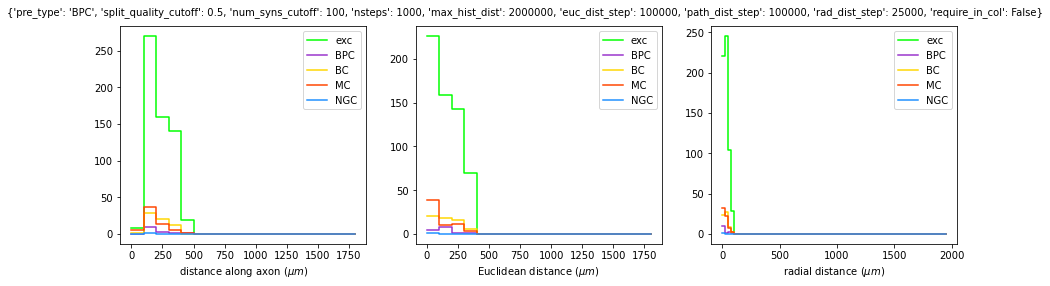

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for cell_type in syn_dfs:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
for cell_type in syn_dfs:
    axes[2].step(rad_bin_edges[:-1]/1000, rad_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[2].set_xlabel("radial distance ($\mu m$)")
axes[2].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [141]:
fig.savefig(os.path.join(results_dir, results_fname + "_hists.png"))

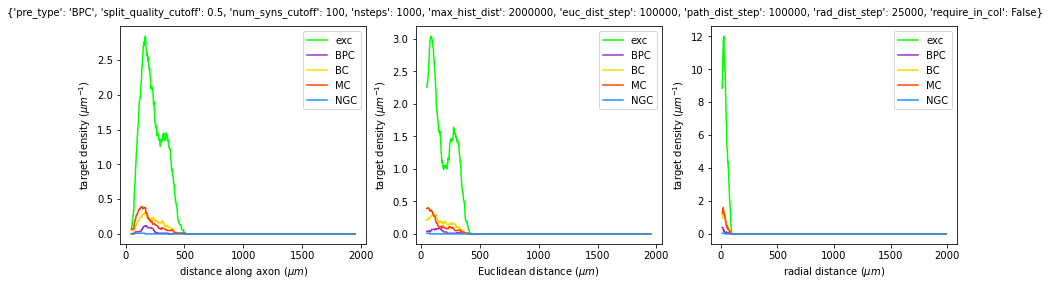

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for cell_type in syn_dfs:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
for cell_type in syn_dfs:
    axes[2].plot(rad_bin_locs/1000, 1000*rad_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[2].set_xlabel("radial distance ($\mu m$)")
axes[2].set_ylabel("target density ($\mu m^{-1}$)")
axes[2].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [143]:
fig.savefig(os.path.join(results_dir, results_fname + "_densities.png"))

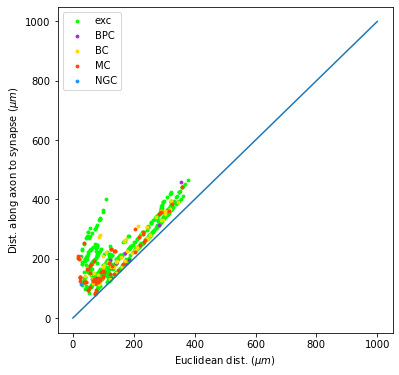

In [144]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [145]:
fig.savefig(os.path.join(results_dir, results_fname + "_euc_v_path.png"))

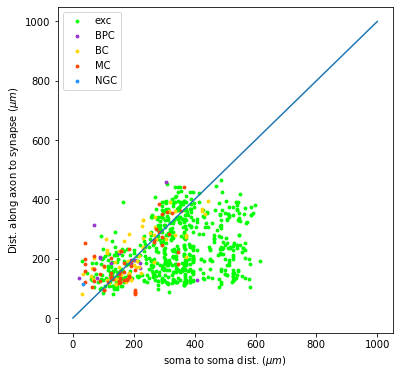

In [146]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [147]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_path.png"))

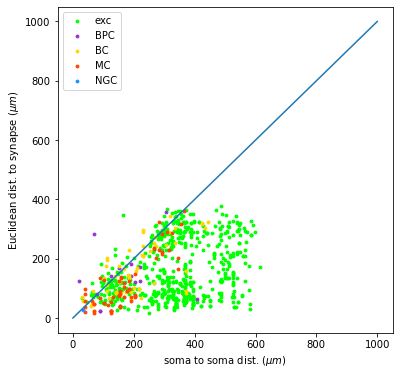

In [148]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [149]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_euc.png"))

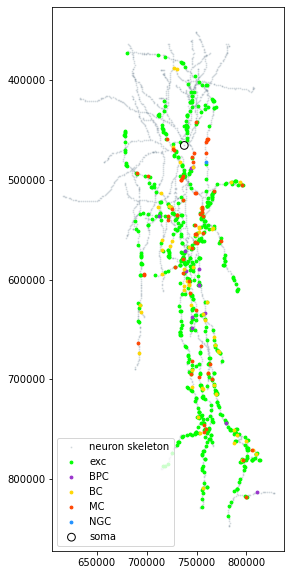

In [150]:
# plot the skeleton
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(1)
ax.scatter(skel_vertices[:, 0], skel_vertices[:, 1], s=1, alpha=.2, c="lightslategrey", label="neuron skeleton")
for cell_type in syn_dfs:
    syn_locs = syn_dfs[cell_type].pre_pt_position.apply(vx_to_nm).values
    if len(syn_locs) > 0:
        syn_locs = np.stack(syn_locs)
        ax.scatter(syn_locs[:, 0], syn_locs[:, 1], s=8, c=type_colors[cell_type], alpha=1, label=cell_type)
ax.scatter(soma_loc[0], soma_loc[1], s=60, marker="o", facecolors='none', edgecolors='k', label="soma")
ax.invert_yaxis()
plt.legend()
plt.show()

In [151]:
fig.savefig(os.path.join(results_dir, results_fname + "_skeleton.png"))